In [1]:
#data manipulation
import pandas as pd
import numpy as np
import sklearn

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

#saving
import pickle

In [2]:
df = pd.read_csv("dataset_diabetes/diabetic_data.csv")

In [3]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Ok so now we have our data loaded into our pandas dataframe. <br />
We are going to start off with some general exploratory data analysis just because it's fun. <br />
This project is a pretty standard cut-and-dry logistic regression/random forrest binary classification task so EDA isn't like /a bad idea/ but I don't think it's strictly necessary here.

In [4]:
print(df.shape)
df.info()

(101766, 50)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int

So this dataset contains 101766 rows, each with 50 columns, where column 49 (readmitted) is our target value. Interestingly, while there are many corrupted or incomplete data values in this set (as well see later) none of the entries are explicitly null. <br />
This isn't a huge issue it just means we can't use certain pandas null-checking functions

In [5]:
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


This really doesn't tell us a whole lot to be honest. Some of the info is worth noting, like time in hospital, number of lab procedures, number of medications, and number of various hospital encounters within the last year. A lot of the generally numbered attributes such as weight are nominal attributes in this dataset because theyre're entered as a range instead of a single value.

In [6]:
#Let's take a look specifically at the weight column for just a second
df['weight'].head()

0    ?
1    ?
2    ?
3    ?
4    ?
Name: weight, dtype: object

As we can see, many of the values in this column, as well as a couple other columns are null ("?" specifically). <br />
Generally, we would have to do some math to figure out the distribution of the values in the... problematic columns but luckily the dataset authors have provided a link to a paper that's already done this for us. <br />
http://www.hindawi.com/journals/bmri/2014/781670/

From this paper we can see 97% of the weight values are missing: <br />
52% of the payer code values are missing <br />
53% of the medical specialty values are missing <br />
2% of the race values are missing <br />
1% of the diagnosis 3 values are missing <br />

While I think we can work around the missing race and diagnosis 3 values, the weight, payer code, and medical speciality columns are simply too incomplete to be worth while and will be dropped. I would have liked to keep weight, but I don't think medical speciality and payer code will have much of a contribution to the chances of readmission

In [7]:
df = df.drop(['weight','payer_code','medical_specialty'],axis=1)
print("New dataframe Shape",df.shape)

New dataframe Shape (101766, 47)


We're also going to fix the target values. <br />
Right now the readmitted column contains 3 categories: No, >30, and <30 <br />
In this project we only care about if the patient was admitted within 30 days of previous admission. So, we're going to replace the values in the target column to binary classifiers - 1 for readmitted with 30 days and 0 for not readmitted within 30 days.

In [8]:
df['readmitted'] = df['readmitted'].replace("<30",1)
df['readmitted'] = df['readmitted'].replace([">30","NO"],0)

print("Our new dataframe")
df.head(10)

Our new dataframe


,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,...,No,No,No,No,No,No,No,No,No,0
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,0
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,0
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,0
5,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,31,...,No,Steady,No,No,No,No,No,No,Yes,0
6,55842,84259809,Caucasian,Male,[60-70),3,1,2,4,70,...,No,Steady,No,No,No,No,No,Ch,Yes,0
7,63768,114882984,Caucasian,Male,[70-80),1,1,7,5,73,...,No,No,No,No,No,No,No,No,Yes,0
8,12522,48330783,Caucasian,Female,[80-90),2,1,4,13,68,...,No,Steady,No,No,No,No,No,Ch,Yes,0
9,15738,63555939,Caucasian,Female,[90-100),3,3,4,12,33,...,No,Steady,No,No,No,No,No,Ch,Yes,0


Let's look at the distribution of our target variable to make sure out dataset is balanced

0    90409
1    11357
Name: readmitted, dtype: int64


array([[<AxesSubplot: title={'center': 'readmitted'}>]], dtype=object)

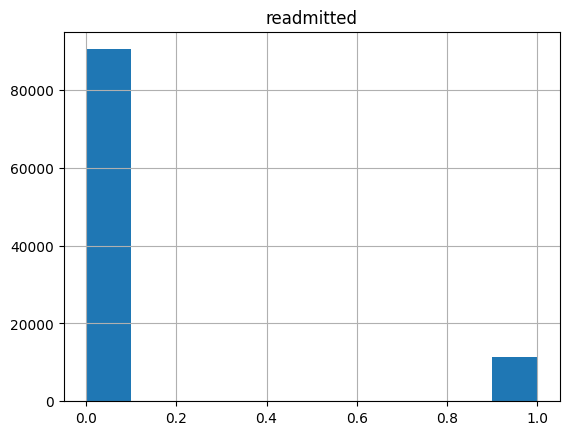

In [9]:
print(df['readmitted'].value_counts())

df.hist('readmitted')

Roughly 10% of our target variables are 1 (readmitted within 30 days) <br />
That's an ehhhhh distribution and may require some dataset balancing techniques. For now we'll attempt just some simple random over-sampling.

We're going to use seaborns pairplot to display all variables against each other in a scatter plot. This can help us spot interesting relationships without having to go through ever value manually. <br />
Interestingly, after running this block the file becomes too large to save hehe. We'll save it to a png on the first pass and just load that png on all subsequent passes.

In [10]:
#pairplot = sns.pairplot(df)
#plt.savefig("pairplot.png")

#I commented out the code to actually create and save the pairplot because
#it takes a long time to run, I've already done it once and just saved
#the image so I can display it that way :)
import matplotlib.image as mpimg

#img = mpimg.imread('pairplot.png')
#imgplot = plt.imshow(img)
#plt.show()

C:\Users\rgleaton\AppData\Local\Temp\ipykernel_19960\3905811639.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = df.corr()


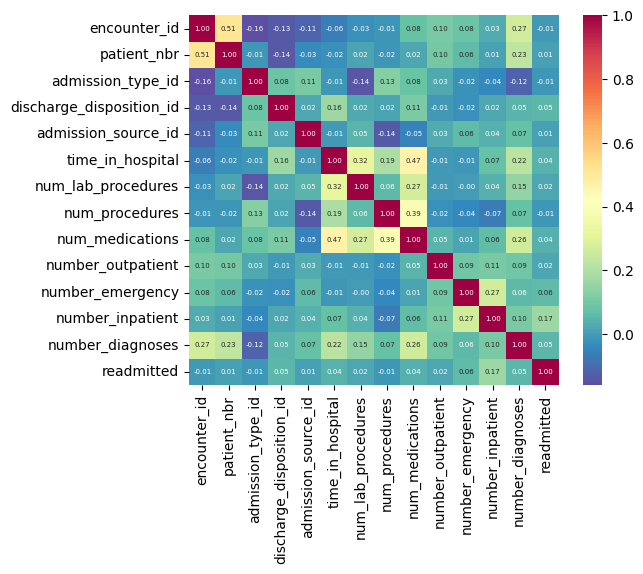

In [11]:
corrmat = df.corr()
hm = sns.heatmap(corrmat, 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 5}, 
                 cmap="Spectral_r")
plt.savefig("heatmap.png")

Above we can see how correlated certain pairs of variables are.
The strongest correlation appears to be between number of lab procedures and number of medications.

Lets now do some comparisons using seaborns kenerl density estimate (KDE) plot. This will show us the probability density curve. This will easily let us see if certain features have desnity differences between readmission and no readmission (within 30 days)

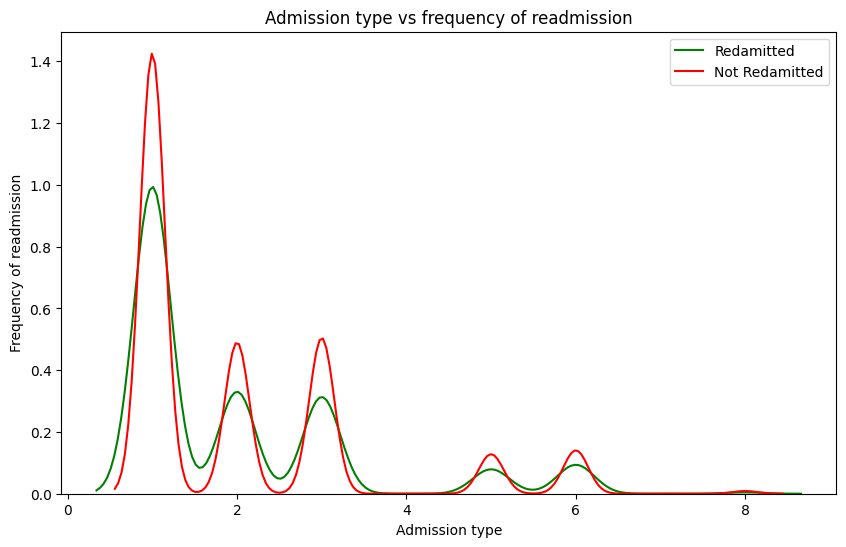

In [36]:
fig = plt.figure(figsize=(10,6))
ax = sns.kdeplot(df.loc[(df['readmitted']==1), 'admission_type_id'], color='g', label='Redamitted')
ax = sns.kdeplot(df.loc[(df['readmitted']==0), 'admission_type_id'], color='r', label='Not Redamitted')
ax.set(xlabel="Admission type", ylabel="Frequency of readmission")
ax.legend()
plt.title("Admission type vs frequency of readmission")
plt.savefig("admission_type_vs_readmission.png")

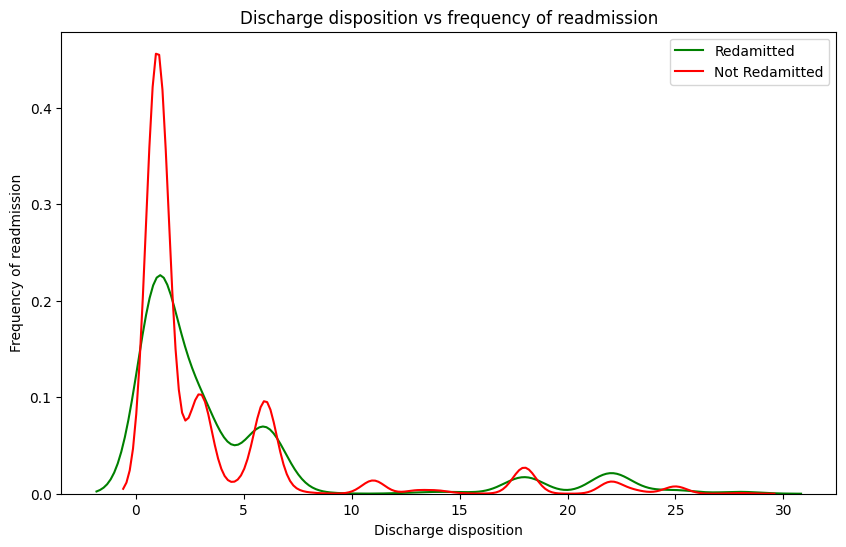

In [30]:
fig = plt.figure(figsize=(10,6))
ax = sns.kdeplot(df.loc[(df['readmitted']==1), 'discharge_disposition_id'], color='g', label='Redamitted')
ax = sns.kdeplot(df.loc[(df['readmitted']==0), 'discharge_disposition_id'], color='r', label='Not Redamitted')
ax.set(xlabel="Discharge disposition", ylabel="Frequency of readmission")
ax.legend()
plt.title("Discharge disposition vs frequency of readmission")
plt.savefig("discharge_disposition_vs_readmission.png")

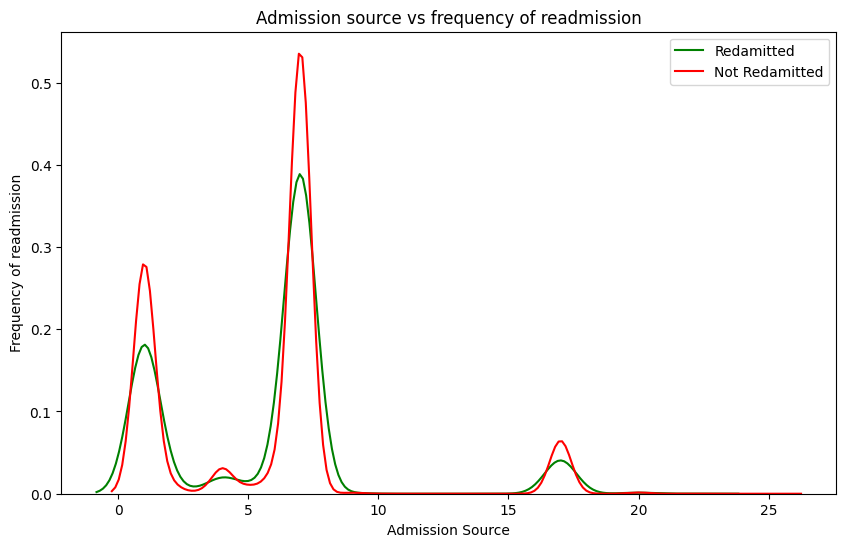

In [31]:
fig = plt.figure(figsize=(10,6))
ax = sns.kdeplot(df.loc[(df['readmitted']==1), 'admission_source_id'], color='g', label='Redamitted')
ax = sns.kdeplot(df.loc[(df['readmitted']==0), 'admission_source_id'], color='r', label='Not Redamitted')
ax.set(xlabel="Admission Source", ylabel="Frequency of readmission")
ax.legend()
plt.title("Admission source vs frequency of readmission")
plt.savefig("admission_source_vs_readmission.png")

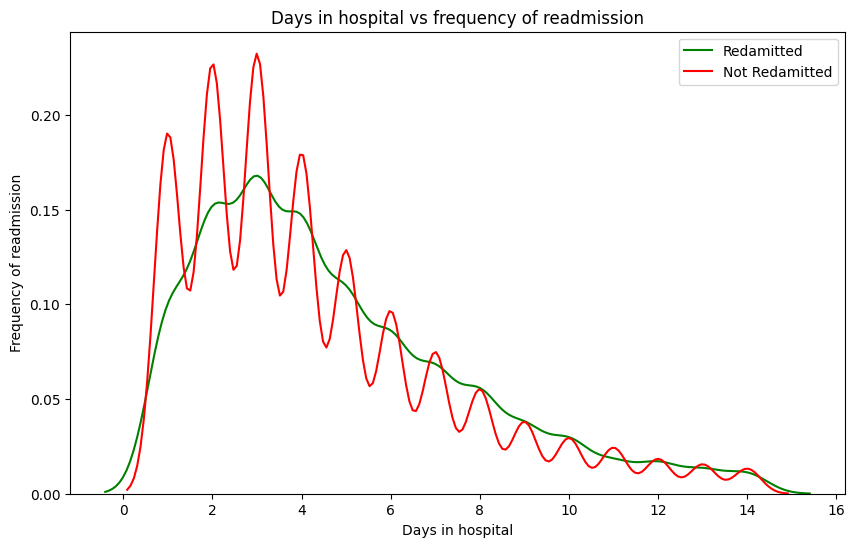

In [28]:
fig = plt.figure(figsize=(10,6))
ax = sns.kdeplot(df.loc[(df['readmitted']==1), 'time_in_hospital'], color='g', label='Redamitted')
ax = sns.kdeplot(df.loc[(df['readmitted']==0), 'time_in_hospital'], color='r', label='Not Redamitted')
ax.set(xlabel="Days in hospital", ylabel="Frequency of readmission")
ax.legend()
plt.title("Days in hospital vs frequency of readmission")
plt.savefig("days_in_hospital_vs_readmission.png")

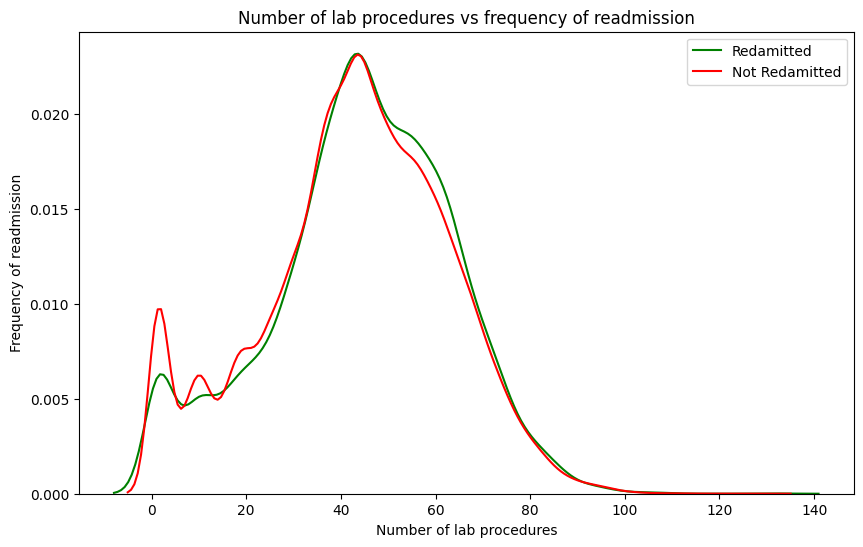

In [32]:
fig = plt.figure(figsize=(10,6))
ax = sns.kdeplot(df.loc[(df['readmitted']==1), 'num_lab_procedures'], color='g', label='Redamitted')
ax = sns.kdeplot(df.loc[(df['readmitted']==0), 'num_lab_procedures'], color='r', label='Not Redamitted')
ax.set(xlabel="Number of lab procedures", ylabel="Frequency of readmission")
ax.legend()
plt.title("Number of lab procedures vs frequency of readmission")
plt.savefig("num_lab_procedures_vs_readmission.png")

This plot below is for procedures other than labs

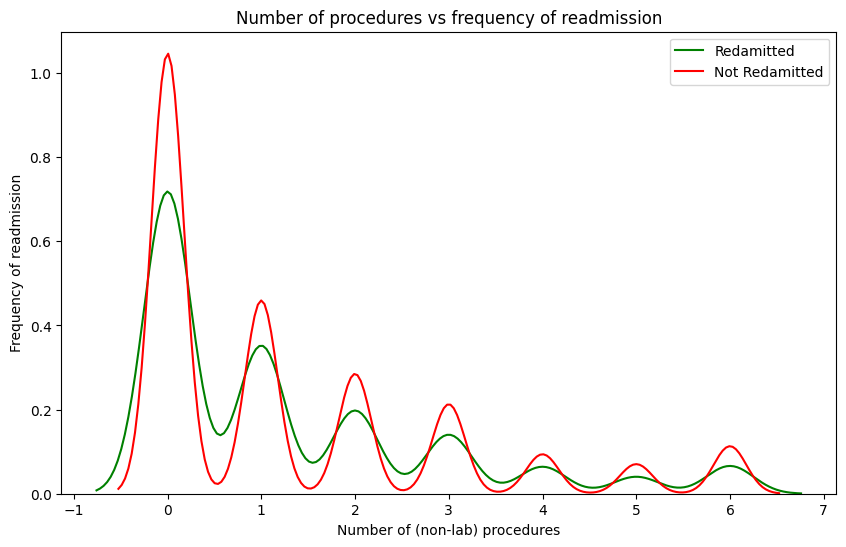

In [33]:
fig = plt.figure(figsize=(10,6))
ax = sns.kdeplot(df.loc[(df['readmitted']==1), 'num_procedures'], color='g', label='Redamitted')
ax = sns.kdeplot(df.loc[(df['readmitted']==0), 'num_procedures'], color='r', label='Not Redamitted')
ax.set(xlabel="Number of (non-lab) procedures", ylabel="Frequency of readmission")
ax.legend()
plt.title("Number of procedures vs frequency of readmission")
plt.savefig("num_procedures_vs_readmission.png")

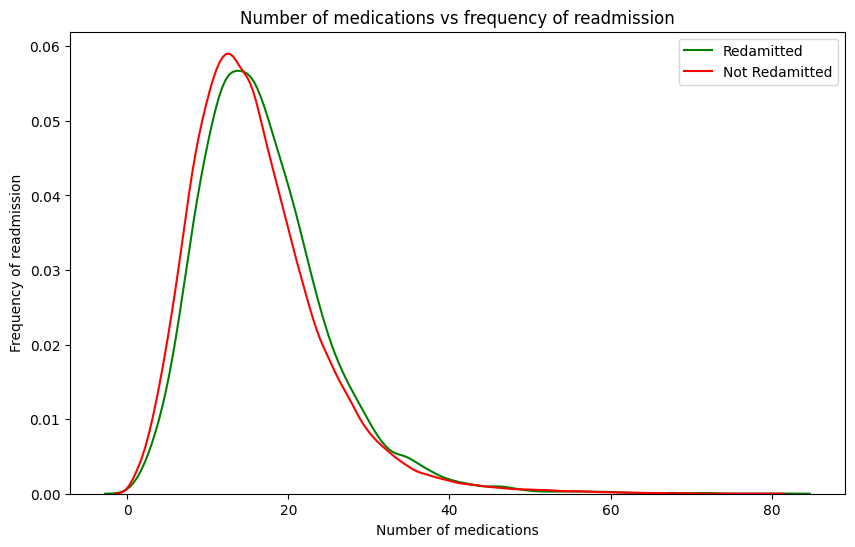

In [37]:
fig = plt.figure(figsize=(10,6))
ax = sns.kdeplot(df.loc[(df['readmitted']==1), 'num_medications'], color='g', label='Redamitted')
ax = sns.kdeplot(df.loc[(df['readmitted']==0), 'num_medications'], color='r', label='Not Redamitted')
ax.set(xlabel="Number of medications", ylabel="Frequency of readmission")
ax.legend()
plt.title("Number of medications vs frequency of readmission")
plt.savefig("num_medications_vs_readmission.png")

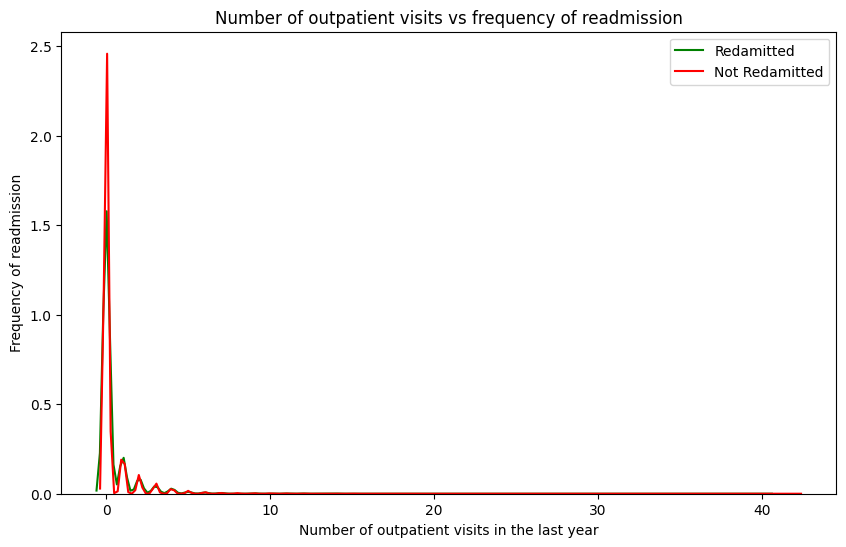

In [41]:
fig = plt.figure(figsize=(10,6))
ax = sns.kdeplot(df.loc[(df['readmitted']==1), 'number_outpatient'], color='g', label='Redamitted')
ax = sns.kdeplot(df.loc[(df['readmitted']==0), 'number_outpatient'], color='r', label='Not Redamitted')
ax.set(xlabel="Number of outpatient visits in the last year", ylabel="Frequency of readmission")
ax.legend()
plt.title("Number of outpatient visits vs frequency of readmission")
plt.savefig("num_outpatient_vs_readmission.png")

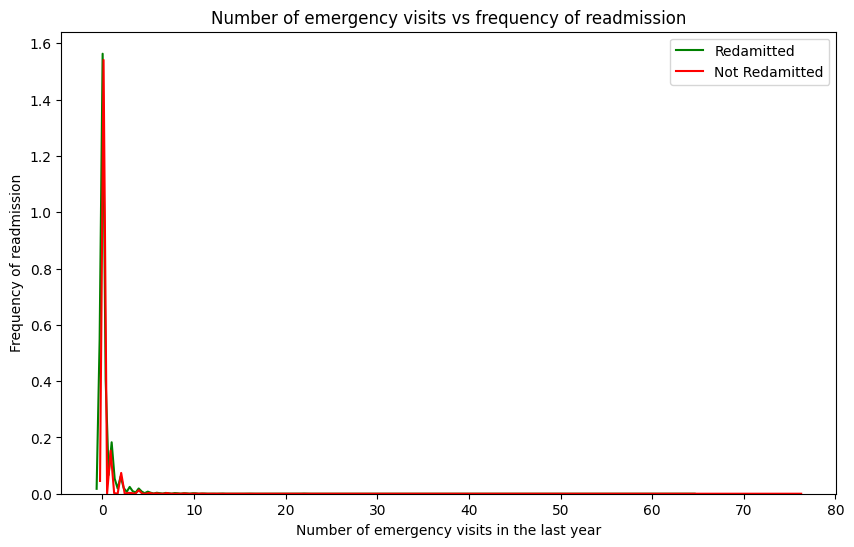

In [40]:
fig = plt.figure(figsize=(10,6))
ax = sns.kdeplot(df.loc[(df['readmitted']==1), 'number_emergency'], color='g', label='Redamitted')
ax = sns.kdeplot(df.loc[(df['readmitted']==0), 'number_emergency'], color='r', label='Not Redamitted')
ax.set(xlabel="Number of emergency visits in the last year", ylabel="Frequency of readmission")
ax.legend()
plt.title("Number of emergency visits vs frequency of readmission")
plt.savefig("num_emergency_vs_readmission.png")

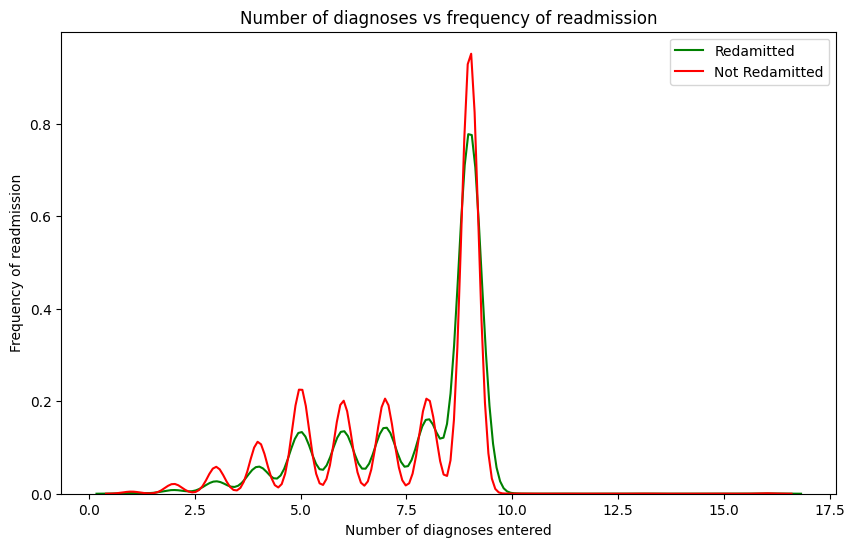

In [43]:
fig = plt.figure(figsize=(10,6))
ax = sns.kdeplot(df.loc[(df['readmitted']==1), 'number_diagnoses'], color='g', label='Redamitted')
ax = sns.kdeplot(df.loc[(df['readmitted']==0), 'number_diagnoses'], color='r', label='Not Redamitted')
ax.set(xlabel="Number of diagnoses entered", ylabel="Frequency of readmission")
ax.legend()
plt.title("Number of diagnoses vs frequency of readmission")
plt.savefig("num_diagnosis_vs_readmission.png")

Nothing too interesting there. We'll check the histograms for a couple of the likely more important tests then move on to model set up and training.

The glu serum test test your blood glucose levels and is used to screen for diabetes according to Cleveland Clinic.
https://my.clevelandclinic.org/health/diagnostics/12363-blood-glucose-test

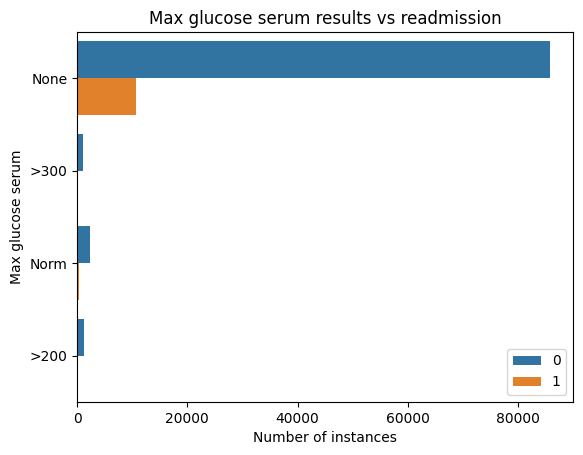

In [52]:
ax=sns.countplot(y=df['max_glu_serum'], hue=df['readmitted'])
ax.set(xlabel="Number of instances", ylabel="Max glucose serum")
ax.legend()
plt.title("Max glucose serum results vs readmission")
plt.savefig("max_glu_serum_vs_readmission.png")

The A1C test is a common blood test used to diagnose type 1 and type 2 diabetes. It reflects your average blood sugar level for the past few months according to Mayo Clinic. https://www.mayoclinic.org/tests-procedures/a1c-test/about/pac-20384643

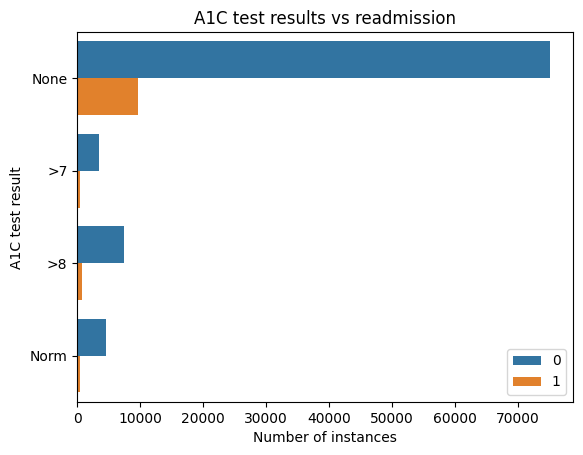

In [53]:
ax=sns.countplot(y=df['A1Cresult'], hue=df['readmitted'])
ax.set(xlabel="Number of instances", ylabel="A1C test result")
ax.legend()
plt.title("A1C test results vs readmission")
plt.savefig("A1c_vs_readmission.png")

Alright, just because I'm essentially certain they aren't useful I'm going to go ahead and drop encounter id and patient number. They'll probably throw off certain models anyways as they're pretty large numbers

In [54]:
df = df.drop(['encounter_id','patient_nbr'], axis=1)

In [55]:
df['citoglipton'].describe()

count     101766
unique         1
top           No
freq      101766
Name: citoglipton, dtype: object

We'll also drop this column as it only has one value

In [56]:
df = df.drop(['citoglipton'], axis=1)

I'm going to attempt to use sklearn's simple imputer to replace missing values with a constant string. <br />
In this case we'll set the constant string to "missing", I had thought's about using a k-nearest neighbours imputer which still may work but it was too much work to set up and I don't think it'll matter too much in this instance. <br />
First I'll have to do some prep work and replace the "?"s with None as setup. <br />
Then we'll replace missing data and encode everything to numeric data for our classifier. <br />

In [57]:
df = df.replace("?","missing")

We're now going to replace some of the categorical features with numeric features by hand to set up some feature selection later down the line

In [58]:
df['age'] = df['age'].replace('[0-10)',10)
df['age'] = df['age'].replace('[10-20)',20)
df['age'] = df['age'].replace('[20-30)',30)
df['age'] = df['age'].replace('[30-40)',40)
df['age'] = df['age'].replace('[40-50)',50)
df['age'] = df['age'].replace('[50-60)',60)
df['age'] = df['age'].replace('[60-70)',70)
df['age'] = df['age'].replace('[70-80)',80)
df['age'] = df['age'].replace('[80-90)',90)
df['age'] = df['age'].replace('[90-100)',100)

df['age'].head()

0    10
1    20
2    30
3    40
4    50
Name: age, dtype: int64

In [59]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

#Find the categorical features we'll have to encode to numeric features
features_to_encode = df.columns[df.dtypes==object].tolist()
print("Number of categorical features: ",len(features_to_encode))
features_to_encode

Number of categorical features:  31


['race',
 'gender',
 'diag_1',
 'diag_2',
 'diag_3',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed']

We'll now do some one-hot encoding using pd.get_dummies to transform our categorical data into numeric data. This way our ML algorithms will actually be able to process the data.

In [60]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feature in features_to_encode:
    df[feature]=le.fit_transform(df[feature])
    
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,examide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2,0,10,6,25,1,1,41,0,1,...,0,1,1,0,0,0,0,1,0,0
1,2,0,20,1,1,7,3,59,0,18,...,0,3,1,0,0,0,0,0,1,0
2,0,0,30,1,1,7,2,11,5,13,...,0,1,1,0,0,0,0,1,1,0
3,2,1,40,1,1,7,2,44,1,16,...,0,3,1,0,0,0,0,0,1,0
4,2,1,50,1,1,7,1,51,0,8,...,0,2,1,0,0,0,0,0,1,0


In [61]:
#Split into train and test set
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=1337)

In [62]:
#Split into features/inputs (x) and target (y)
train_x = train[train.columns[0:-1]]
test_x = test[test.columns[0:-1]]

train_y = train['readmitted']
test_y = test['readmitted']

In [63]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy=0.75)
train_x, train_y = undersample.fit_resample(train_x, train_y)

In [64]:
#Random forest
from sklearn.ensemble import RandomForestClassifier

#rf_classifier = RandomForestClassifier(n_estimators=200, max_depth=50, class_weight="balanced_subsample", bootstrap=True, n_jobs=-1, random_state=43)
rf_classifier = RandomForestClassifier(n_estimators=250, max_depth=15, n_jobs=-1, criterion="entropy", random_state=43)

In [65]:
rf_classifier.fit(train_x, train_y)

RandomForestClassifier(criterion='entropy', max_depth=15, n_estimators=250,
                       n_jobs=-1, random_state=43)

In [67]:
#Save model
pickle.dump(rf_classifier, open("rf.sav","wb"))

So we've trained our random forrest. <br />
First thing we'll do is check the Receiver Operating Characteristic (ROC) curve. A ROC curve is just a plot that shows how well your binary classifier operates as its discrimination threshold is varied. The Y-Axis is is the True Positive Rate and the X-Axis is the False Positive Rate. Ideally you want youre graph to look like a completely straight line going straight up the X-Axis, with a sharp 90 degree turn at the top and continuing in a straight line to the right at Y=1.0

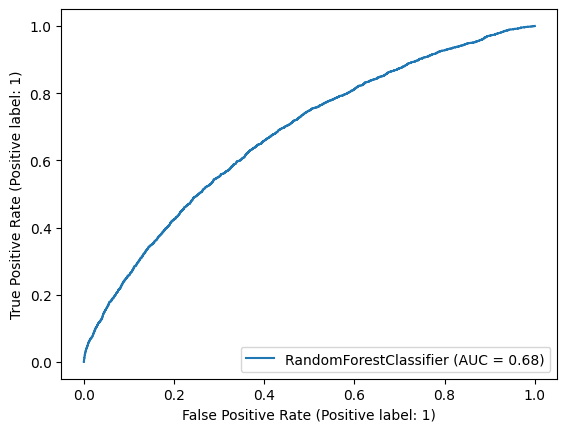

In [69]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(rf_classifier, test_x, test_y)
plt.show()

This ROC curve is already pretty good, though lets preform some hyper parameter tunning and see if we can get it just a little bit better before fully evaluating our model

In [70]:
#Getting the names of parameters we can set for tunning
rf_classifier.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [73]:
from sklearn.model_selection import GridSearchCV

#Set the parameters we want to tune and the values we wants to test
param_grid={
    'n_estimators': [100,250],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy',],
    'max_depth': [5, 10, 15, 25],
    'min_samples_split': [2,5,10]
}
rf_classifier = pickle.load(open("rf.sav", 'rb')) #Load model so we can restart kernel w/ out having to retrain
clf_hyper = GridSearchCV(rf_classifier, param_grid, cv=3, scoring='recall', verbose=1)

#Start searching for the best combo
clf_hyper.fit(train_x, train_y)
pickle.dump(clf_hyper, open("rf_hyper.sav","wb")) #Save

Fitting 3 folds for each of 96 candidates, totalling 288 fits


Now that we've found the best parameters for our random forest lets take a look at what they are

In [74]:
clf_hyper.best_params_

{'criterion': 'entropy',
 'max_depth': 25,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_estimators': 100}

In [75]:
clf_hyper.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=25, n_jobs=-1,
                       random_state=43)

In [76]:
#Ok, let's create a random forest with these parameters and see if we can do any better
rf_hyper = clf_hyper.best_estimator_
rf_hyper.fit(train_x, train_y)

RandomForestClassifier(criterion='entropy', max_depth=25, n_jobs=-1,
                       random_state=43)

In [77]:
#Save model
pickle.dump(rf_hyper, open("rf_hyper.sav","wb"))

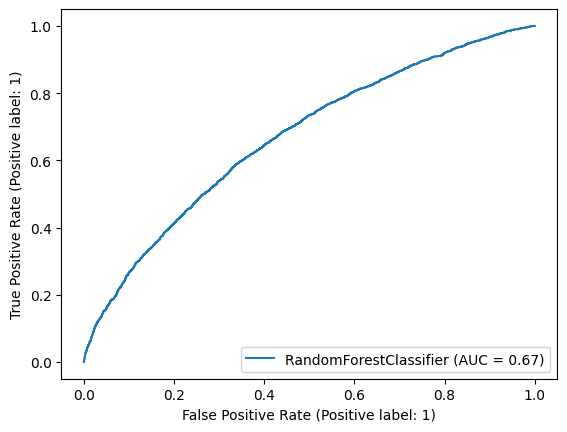

In [79]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(rf_hyper, test_x, test_y)
plt.show()

In [80]:
test_predict_Y = rf_classifier.predict(test_x)

In [81]:
#Calculate confusion matrix items
#Standard random forest
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y, test_predict_Y, labels=[0, 1])

FN = cm.sum(axis=0) - np.diag(cm)  
FP = cm.sum(axis=1) - np.diag(cm)
TN = np.diag(cm)
TP = cm.sum() - (FP + FN + TN)

print(cm)
print("False Positive Rates: ",FP)
print("False Negative Rates: ",FN)
print("True Positive Rates: ", TP)
print("True Negative Rates: ",TN)

[[15144  2984]
 [ 1402   824]]
False Positive Rates:  [2984 1402]
False Negative Rates:  [1402 2984]
True Positive Rates:  [  824 15144]
True Negative Rates:  [15144   824]


In [82]:
test_predict_Y = rf_hyper.predict(test_x)

In [83]:
#Calculate confusion matrix items
#Random forest with hyper-parameter tunning
cm = confusion_matrix(test_y, test_predict_Y, labels=[0, 1])

FN = cm.sum(axis=0) - np.diag(cm)  
FP = cm.sum(axis=1) - np.diag(cm)
TN = np.diag(cm)
TP = cm.sum() - (FP + FN + TN)

print(cm)
print("False Positive Rates: ",FP)
print("False Negative Rates: ",FN)
print("True Positive Rates: ", TP)
print("True Negative Rates: ",TN)

[[14427  3701]
 [ 1298   928]]
False Positive Rates:  [3701 1298]
False Negative Rates:  [1298 3701]
True Positive Rates:  [  928 14427]
True Negative Rates:  [14427   928]


As a note the confusion matrix is displayed as: <br />
TN | FP <br />
FN | TP <br />
<br />
Just eyeballing the ROC curves, the random forest w/ hyper-parameter (HP) tunning appears to have a better recall, though that's at the cost of precision. I suspect it'll have a lower f1 score. Not really sure which model is 'better', it depends on how you choose to evaluate. <br />
<br />
My goal was to achieve the best recall possible, so in that sense it appears the random forest with hyper parameter tunning performs better. Though it's not by a huge margin.

In [84]:
#Precision
from sklearn.metrics import precision_score

test_predict_Y = rf_classifier.predict(test_x)
print("Precision random forest: ",precision_score(test_y, test_predict_Y, average='binary'))

test_predict_Y = rf_hyper.predict(test_x)
print("Precision random forest w/ HP Tunning: ",precision_score(test_y, test_predict_Y, average='binary'))

Precision random forest:  0.21638655462184875
Precision random forest w/ HP Tunning:  0.2004752646359905


Precision is the number of true positives over true positives+false positives. <br />
It's the percentage of positive predictions that are actually positive. Here we can see that in fact the random forest w/ out hyper parameter tunning is better in this regard.

In [85]:
#Recall
#TP/(TP+FN) 
#The percentage of positive predictions out of the total number of positive instances 
from sklearn.metrics import recall_score

test_predict_Y = rf_classifier.predict(test_x)
print("Recall random forest: ",recall_score(test_y, test_predict_Y, average='binary'))

test_predict_Y = rf_hyper.predict(test_x)
print("Recall random forest w/ HP Tunning: ",recall_score(test_y, test_predict_Y, average='binary'))

Recall random forest:  0.3701707097933513
Recall random forest w/ HP Tunning:  0.4168912848158131


While our tunned model may have slightly lower precision, it has much higher recall, meaning it catches more actually positive results.

In [86]:
#F1 Score
#Harmonic mean of precision and recall
from sklearn.metrics import f1_score

test_predict_Y = rf_classifier.predict(test_x)
print("F1 random forest: ",f1_score(test_y, test_predict_Y, average='binary'))

test_predict_Y = rf_hyper.predict(test_x)
print("F1 random forest w/ HP Tunning: ",f1_score(test_y, test_predict_Y, average='binary'))

F1 random forest:  0.273118992376533
F1 random forest w/ HP Tunning:  0.27075127644055436


The f1 scores are about even, though the random forest w/ out tunning produces a better result still.

In [87]:
#R2 Score
#The total variance explained by the model over the total variance
#A high score means a high correlation which is what we want
from sklearn.metrics import r2_score

test_predict_Y = rf_classifier.predict(test_x)
print("R2 random forest: ",r2_score(test_y, test_predict_Y))

test_predict_Y = rf_hyper.predict(test_x)
print("R2 random forest w/ HP Tunning: ",r2_score(test_y, test_predict_Y))

R2 random forest:  -1.2122965649481494
R2 random forest w/ HP Tunning:  -1.5214935084760146


Yikes... we're just going to move on from this.

In [88]:
#Accuracy score
#Just how accurate the model is, pretty self explanetory 
from sklearn.metrics import accuracy_score

test_predict_Y = rf_classifier.predict(test_x)
print("Accuracy random forest: ",accuracy_score(test_y, test_predict_Y))

test_predict_Y = rf_hyper.predict(test_x)
print("Accuracy random forest w/ HP Tunning: ",accuracy_score(test_y, test_predict_Y))

Accuracy random forest:  0.7845141004225213
Accuracy random forest w/ HP Tunning:  0.7543971700894173


In [90]:
#MAE Score
#Mean absolute error
from sklearn.metrics import mean_absolute_error

test_predict_Y = rf_classifier.predict(test_x)
print("MAE random forest: ",mean_absolute_error(test_y, test_predict_Y))

test_predict_Y = rf_hyper.predict(test_x)
print("MAE random forest w/ HP Tunning: ",mean_absolute_error(test_y, test_predict_Y))

MAE random forest:  0.21548589957747863
MAE random forest w/ HP Tunning:  0.2456028299105827


In [57]:
#Mean Squared Error (MSE)
from sklearn.metrics import mean_squared_error

test_predict_Y = rf_classifier.predict(test_x)
print("MSE random forest: ",mean_squared_error(test_y, test_predict_Y))

test_predict_Y = rfc_hyper.predict(test_x)
print("MSE random forest w/ HP Tunning: ",mean_squared_error(test_y, test_predict_Y))

MSE random forest:  0.021199719795007926
MSE random forest w/ HP Tunning:  0.01640673966744092


Lets try out logistic regression to see if it's any better (I'm pretty confident it won't be).

In [94]:
from sklearn.linear_model import LogisticRegression

logReg = LogisticRegression(penalty='l2',max_iter=5000)

In [95]:
#Train our model
logReg.fit(train_x,train_y)

LogisticRegression(max_iter=5000)

In [97]:
#Save model
import pickle 

pickle.dump(logReg, open("logistic_regression.sav","wb"))

Sometimes depending on the start state and random list of training samples we'll get a warning telling us the model failed to converge with 'only' 5,000 iterations. Luckily, this time it doesn't appear to have happened. My initial guess is that this will be worse than the random forest. But let's take a look.

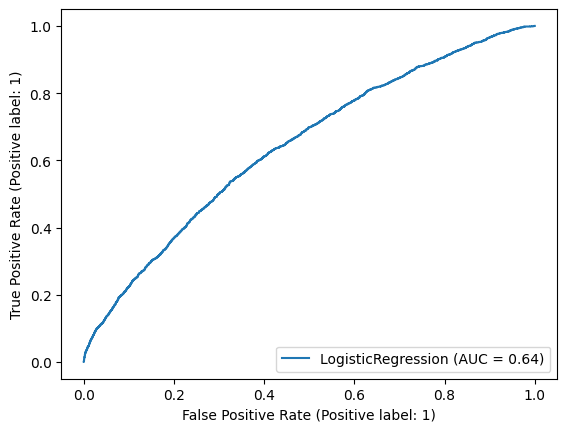

In [100]:
RocCurveDisplay.from_estimator(logReg, test_x, test_y)
plt.show()

In [102]:
#Calculate confusion matrix items
#Logistic Regression
from sklearn.metrics import confusion_matrix

test_predict_Y = logReg.predict(test_x)
cm = confusion_matrix(test_y, test_predict_Y)

FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

print(cm)
print("False Positive Rates: ",FP)
print("False Negative Rates: ",FN)
print("True Positive Rates: ", TP)
print("True Negative Rates: ",TN)

[[15228  2900]
 [ 1538   688]]
False Positive Rates:  [1538 2900]
False Negative Rates:  [2900 1538]
True Positive Rates:  [15228   688]
True Negative Rates:  [  688 15228]


Just from initial assessment, we can already tell the performance of this model is worse than the random forest. The TP and TN rates are lower by a large amount in both instances.

For the purposes of this project I'm happy with this results. If this was a real project to develop a model to be actually used in the real world I would spend longer doing EDA and testing more models/parameters. Though, while I understand to some degree I'm supposed to treat it like it is, it isn't. This is closer to a proof of concept to display how I'd generally tackle this kind of problem more than a deep dive into this specific instance. 

In [113]:
#https://stackoverflow.com/questions/66491801/i-got-this-error-dataframe-dtypes-for-data-must-be-int-float-bool-or-categori
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
import xgboost as xgb

params = {
    'n_estimators': 250,
    'eval_metric': 'recall',
    'booster':'gtree',
    'max_depth':6,
    'eta':0.03,
    'eval_metric':'auc',
    'nthread':8,
    'colsample_bytree':0.5,
    'scale_pos_weight':1.1,
    'early_stopping_rounds': 7
}

dtrain=xgb.DMatrix(data=train_x, label=train_y)

xgb_model = xgb.XGBClassifier(n_estimators=250,eval_metric=recall_score,booster='gbtree',max_depth=15,eta='0.03',
                              colsample_bytree=0.5, early_Stopping_rounds=10, n_jobs=8, verbose_eval=1, objective='binary:logistic')
xgb_model.fit(train_x,train_y)
hr_pred = xgb_model.predict(test_x)
print(classification_report(test_y, hr_pred))

[13:26:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "early_Stopping_rounds", "verbose_eval" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


              precision    recall  f1-score   support

           0       0.92      0.77      0.84     18128
           1       0.20      0.47      0.28      2226

    accuracy                           0.74     20354
   macro avg       0.56      0.62      0.56     20354
weighted avg       0.84      0.74      0.78     20354



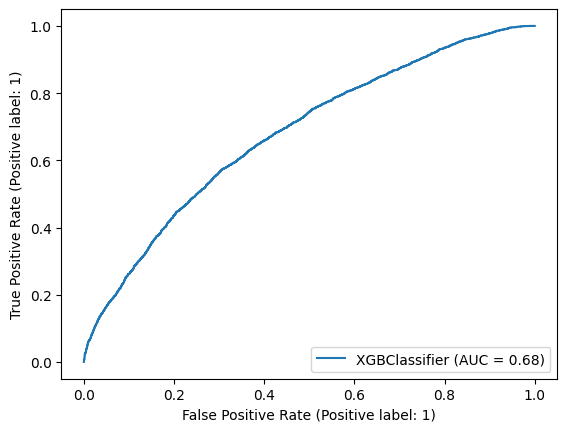

In [114]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(xgb_model, test_x, test_y)
plt.show()

In [117]:
#Calculate confusion matrix items
#Random forest with hyper-parameter tunning
test_predict_Y=xgb_model.predict(test_x)
cm = confusion_matrix(test_y, test_predict_Y, labels=[0, 1])

FN = cm.sum(axis=0) - np.diag(cm)  
FP = cm.sum(axis=1) - np.diag(cm)
TN = np.diag(cm)
TP = cm.sum() - (FP + FN + TN)

print(cm)
print("False Positive Rates: ",FP)
print("False Negative Rates: ",FN)
print("True Positive Rates: ", TP)
print("True Negative Rates: ",TN)

[[13973  4155]
 [ 1178  1048]]
False Positive Rates:  [4155 1178]
False Negative Rates:  [1178 4155]
True Positive Rates:  [ 1048 13973]
True Negative Rates:  [13973  1048]


In [118]:
pickle.dump(xgb_model, open("xgb_classification_rf.sav","wb"))

In [120]:
#Precision
from sklearn.metrics import precision_score

print("Precision xgb random forest: ",precision_score(test_y, test_predict_Y, average='binary'))

Precision xgb random forest:  0.20142225639054392


In [121]:
print("Recall xgb random forest: ",recall_score(test_y, test_predict_Y, average='binary'))

Recall xgb random forest:  0.47079964061096136


In [122]:
from sklearn.metrics import f1_score

print("F1 xgb random forest: ",f1_score(test_y, test_predict_Y, average='binary'))

F1 xgb random forest:  0.28213756898640463


So our XGB classifier has the highest f1 score and recall score. I'm not going to go tunning it to try and get a bit more of performance out of it as the point is moot.</br>
</br>
None of these models predict well enough for me to feel comfortable unleashing them on the world to have doctors make actual patient saftey affecting decisions based on their results.